In [255]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [256]:
df_train = pd.read_csv('data/titanic/train.csv').set_index('PassengerId')
df_test = pd.read_csv('data/titanic/test.csv').set_index('PassengerId')
data = pd.concat([df_train, df_test], sort=False)

* **PassengerId** is the unique id of the row and it doesn't have any effect on target
* **Survived is** the target variable we are trying to predict (0 or 1):
    * 1 = Survived
    * 0 = Not Survived
* **Pclass** (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has 3 unique values (1, 2 or 3):
    * 1 = Upper Class
    * 2 = Middle Class
    * 3 = Lower Class
* **Name, Sex and Age** are self-explanatory
* **SibSp** is the total number of the passengers' siblings and spouse
* **Parch** is the total number of the passengers' parents and children
* **Ticket** is the ticket number of the passenger
* **Fare** is the passenger fare
* **Cabin** is the cabin number of the passenger
* **Embarked** is port of embarkation and it is a categorical feature which has 3 unique values (C, Q or S):
    * C = Cherbourg
    * Q = Queenstown
    * S = Southampton

# Feature Engineering

In [257]:
data['Surname'] = data.Name.str.split(', ', expand=True)[0]
data['TicketId'] = data['Ticket'].apply(lambda x: str(x[:-1]))
data['GroupId'] = data.groupby(['Surname', 'Pclass', 'Fare', 'Embarked', 'TicketId']).ngroup()

In [258]:
def deck_feature(df):
    df['Deck'] = df.Cabin.apply(lambda s: s[0] if pd.notnull(s) else 'M')
    df.Deck.replace('T', 'M', inplace=True)

def group_decks_by_survival_rate(df):
    df['Deck'].replace(['B','D','E'], 'BDE', inplace=True)
    df['Deck'].replace(['F','C'],'FC', inplace=True)
    df['Deck'].replace(['G','A'],'GA', inplace=True)

def titles(df):
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

    # group related titles together
    df['Title'].replace(['Capt','Col','Major','Dr','Rev'], 'Officer', inplace=True)
    df['Title'].replace(['Jonkheer','Don','Sir','the Countess','Dona','Lady'], 'Royalty', inplace=True)
    df['Title'].replace(['Mme','Ms','Mrs'], 'Married woman', inplace=True)
    df['Title'].replace(['Mlle','Miss'], 'Unmarried woman', inplace=True)
    df['Title'].replace(['Mr'], 'Adult man', inplace=True)
    df['Title'].replace(['Master'], 'Young man', inplace=True)

deck_feature(data)
group_decks_by_survival_rate(data)
titles(data)

In [259]:
# fill missing age by median age of title
def fill_missing_age(df):
    df.Age.fillna(df.groupby('Title').Age.transform('median'), inplace=True)

# fill missing fare and zero fare by median fare of pclass
def fill_missing_fare(df):
    df.loc[df.Fare == 0, 'Fare'] = np.nan
    df.Fare.fillna(df.groupby('Pclass').Fare.transform('median'), inplace=True)

# fill missing embarked by mode
def fill_missing_embarked(df):
    df.Embarked.fillna(df.Embarked.mode()[0], inplace=True)

def fill_zero_fare_to_nan(df):
    df.loc[df.Fare == 0, 'Fare'] = np.nan

fill_missing_age(data)
fill_missing_embarked(data)
fill_zero_fare_to_nan(data)

data['TicketFreq'] = data.groupby('Ticket')['Ticket'].transform('count')
data['Pfare'] = data['Fare'] / data['TicketFreq']

# Woman Child Group (WCG)

In [260]:
data['FamilyTitle'] = 'man'
data.loc[data['Sex'] == 'female', 'FamilyTitle'] = 'woman'
data.loc[data['Name'].str.contains('Master'), 'FamilyTitle'] = 'boy'

data.loc[data['FamilyTitle'] == 'man', 'GroupId'] = -1
data['GroupFreq'] = data.groupby('GroupId')['GroupId'].transform('count')
data['GroupId'] = data['GroupId'].where(data['GroupFreq'] > 1, -1)
data['TicketId'] = data.groupby(['Pclass', 'Fare', 'Embarked', 'FamilyTitle', 'TicketId']).ngroup()

count = 0
names = []
for i in data[(data['FamilyTitle'] != 'man') & (data['GroupId'] == -1)].index:
    x = data[data['TicketId'] == data.loc[i, 'TicketId']]['GroupId'].values
    if x.size > 0:
        m = max(x)
        if m != -1:
            data.loc[i, 'GroupId'] = m
            # print family surname of people with same ticket
            names.append(data.loc[data['GroupId'] == m, 'Surname'].values[0])
            count += 1

print(f"We found {count} nannies/relatives and added them to groups.")
print(sorted(names))

We found 11 nannies/relatives and added them to groups.
['Allison', 'Allison', 'Cacic', 'Davies', 'Panula', 'Ryerson', 'Ryerson', 'Spedden', 'Spedden', 'Wick', 'Zabour']


In [261]:
data['GroupSurvival'] = None
data['Survived'] = data['Survived'].astype(float)

data.loc[0:891, 'GroupSurvival'] = data.groupby('GroupId')['Survived'].transform('mean')

for i in range(892, 1310):
    group_id = data.loc[i, 'GroupId']
    data.loc[i, 'GroupSurvival'] = data.loc[data['GroupId'] == group_id, 'GroupSurvival'].iloc[0]

data.loc[(data['GroupSurvival'].isnull()) & (data['Pclass'] == 3), 'GroupSurvival'] = 0
data.loc[(data['GroupSurvival'].isnull()) & (data['Pclass'] != 3), 'GroupSurvival'] = 1

data['Predict'] = 0
data.loc[data['Sex'] == 'female', 'Predict'] = 1
data.loc[(data['FamilyTitle'] == 'woman') & (data['GroupSurvival'] == 0), 'Predict'] = 0
data.loc[(data['FamilyTitle'] == 'boy') & (data['GroupSurvival'] == 1), 'Predict'] = 1

In [262]:
boy_lived = data.loc[(data['Sex'] == 'male') & (data['Predict'] == 1) & (data.index > 891), ['Name', 'FamilyTitle']]
female_die = data.loc[(data['Sex'] == 'female') & (data['Predict'] == 0) & (data.index > 891), ['Name', 'FamilyTitle']]

print(f'{len(boy_lived)} boys predicted to live:')
print(boy_lived, '\n\n\n')
print(f'{len(female_die)} females predicted to die:')
print(female_die)

8 boys predicted to live:
                                        Name FamilyTitle
PassengerId                                             
956              Ryerson, Master. John Borie         boy
981              Wells, Master. Ralph Lester         boy
1053          Touma, Master. Georges Youssef         boy
1086           Drew, Master. Marshall Brines         boy
1088         Spedden, Master. Robert Douglas         boy
1199               Aks, Master. Philip Frank         boy
1284           Abbott, Master. Eugene Joseph         boy
1309                Peter, Master. Michael J         boy 



15 females predicted to die:
                                                          Name FamilyTitle
PassengerId                                                               
910                               Ilmakangas, Miss. Ida Livija       woman
925          Johnston, Mrs. Andrew G (Elizabeth Lily" Watson)"       woman
929                                         Cacic, Miss. Manda       wo

In [263]:
submit = pd.DataFrame({'PassengerId': data.loc[892:1309].index, 'Survived': data.loc[892:1309, 'Predict'].astype(int)})
submit.to_csv('gender_model.csv', index=False)

# Non-WCG
## Males

In [264]:
male_mask = (data['Sex'] == 'male') & (data['GroupId'] == -1)
train_male = data[0:891].loc[male_mask]
test_male = data[891:1309].loc[male_mask]
print(len(train_male))
print(len(test_male))

537
247


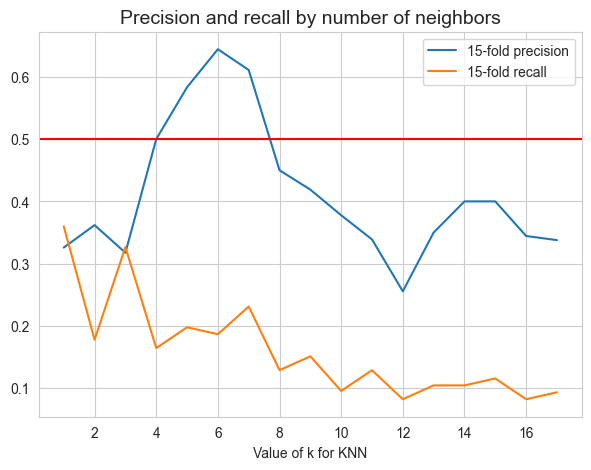

In [265]:
cols = ['PassengerId', 'Name', 'Pfare', 'Pclass', 'Embarked']
features = ['Pfare', 'Pclass', 'Embarked']
numerical_cols = ['Pfare']
categorical_cols = ['Pclass', 'Embarked']

y_m = train_male['Survived']
X_m = train_male[features]


numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

male_preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

precision_m = []
recall_m = []

for k in range(1,18):
    pipeline1 = Pipeline(steps=[
        ('preprocessor', male_preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=k))
    ])
    precision_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='precision').mean())
    recall_m.append(cross_val_score(pipeline1, X_m, y_m, cv=15, n_jobs=-1, scoring='recall').mean())

k_range = range(1,18)
plt.figure(figsize=(7,5))
plt.plot(k_range, precision_m, label='15-fold precision')
plt.plot(k_range, recall_m, label='15-fold recall')
plt.axhline(y=0.5, color='r')
plt.xlabel('Value of k for KNN')
plt.title('Precision and recall by number of neighbors', fontsize=14)
plt.legend()
plt.show()

In [266]:
m1 = KNeighborsClassifier(n_neighbors=1)
m2 = KNeighborsClassifier(n_neighbors=3)
m3 = KNeighborsClassifier(n_neighbors=7)

male_pipeline = Pipeline(steps=[
    ('preprocessor', male_preprocessor),
    ('model', VotingClassifier(estimators=[('m1', m1), ('m2', m2), ('m3', m3)]))
])

male_pipeline.fit(X_m, y_m)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pfare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Embarked'])])),
                ('model',
                 VotingClassifier(estimators=[('m1',
                                               KNeighborsClassifier(n_neighbors=1)),
                                              ('m2',
                                               KNeighborsClassifier(n_neighbors=3)),
                                              ('m3',
                                               KNeighborsClassifier(n_neighbors=7))]))])

In [267]:
import numpy as np
X_test_m = test_male[features]
predictions = male_pipeline.predict(X_test_m)

print(f'The following {len(test_male.loc[predictions == 1])} adult males are predicted to live:')
data.loc[892:1309][male_mask][predictions == 1][['Name', 'Pclass', 'Pfare']]

The following 13 adult males are predicted to live:


C:\Users\tomas\AppData\Local\Temp\ipykernel_12456\2642666279.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data.loc[892:1309][male_mask][predictions == 1][['Name', 'Pclass', 'Pfare']]


,Name,Pclass,Pfare
PassengerId,,,
920,"Brady, Mr. John Bertram",1,30.500000
926,"Mock, Mr. Philipp Edmund",1,28.875000
931,"Hee, Mr. Ling",3,7.061975
942,"Smith, Mr. Lucien Philip",1,30.000000
960,"Tucker, Mr. Gilbert Milligan Jr",1,28.537500
986,"Birnbaum, Mr. Jakob",1,26.000000
987,"Tenglin, Mr. Gunnar Isidor",3,7.795800
1018,"Brobeck, Mr. Karl Rudolf",3,7.795800
1023,"Gracie, Col. Archibald IV",1,28.500000


In [268]:
data.loc[892:1309, 'Predict'][male_mask] = predictions
submit = pd.DataFrame({'PassengerId': data.loc[892:1309].index, 'Survived': data.loc[892:1309, 'Predict'].astype(int)})
submit.to_csv('gender_model2.csv', index=False)

## Females

In [269]:
# female 3rd class
female_mask = (data['Sex'] == 'female') & (data['GroupId'] == -1)  & (data['Pclass'] == 3)
train_female = data[0:891].loc[female_mask]
test_female = data[891:1309].loc[female_mask]
print(len(train_female))
print(len(test_female))

77
46


In [270]:
features = ['Age', 'Title']
numerical_cols = ['Age']
categorical_cols = ['Title']

X_m = train_female[features]
y_m = train_female['Survived']

female_preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [271]:
from xgboost import XGBClassifier
female_pipeline = Pipeline(steps=[
    ('preprocessor', female_preprocessor),
    ('model', XGBClassifier(n_estimators=500, max_depth=5))
])

female_pipeline.fit(X_m, y_m)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Title', 'Embarked'])])),
                ('model',
                 XGBClassifier(base_score=None, boost...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=500,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [272]:
X_test_m = test_female[features]
proba = female_pipeline.predict_proba(X_test_m)[:,1]
predictions = np.where(proba <= 0.3, 0, 1)
print(f'The following {len(test_female.loc[predictions == 0])} females are predicted to die:')
# data with proba column
female = data.loc[892:1309][female_mask][['Name', 'Age', 'Title', 'Pfare', 'Pclass']]
female['proba'] = proba
female[predictions == 0]

The following 6 females are predicted to die:


C:\Users\tomas\AppData\Local\Temp\ipykernel_12456\2423545936.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female = data.loc[892:1309][female_mask][['Name', 'Age', 'Title', 'Pfare', 'Pclass']]


,Name,Age,Title,Pfare,Pclass,proba
PassengerId,,,,,,
893,"Wilkes, Mrs. James (Ellen Needs)",47.0,Married woman,7.00000,3,0.304478
898,"Connolly, Miss. Kate",30.0,Unmarried woman,7.62920,3,0.412479
900,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",18.0,Married woman,7.22920,3,0.296247
911,"Assaf Khalil, Mrs. Mariana (Miriam"")""",45.0,Married woman,7.22500,3,0.344799
928,"Roth, Miss. Sarah A",22.0,Unmarried woman,8.05000,3,0.425813
955,"Bradley, Miss. Bridget Delia",22.0,Unmarried woman,7.72500,3,0.795885
958,"Burns, Miss. Mary Delia",18.0,Unmarried woman,7.87920,3,0.235213
962,"Mulvihill, Miss. Bertha E",24.0,Unmarried woman,7.75000,3,0.415709
964,"Nieminen, Miss. Manta Josefina",29.0,Unmarried woman,7.92500,3,0.885369


In [273]:
data.loc[892:1309, 'Predict'][female_mask] = predictions
submit = pd.DataFrame({'PassengerId': data.loc[892:1309].index, 'Survived': data.loc[892:1309, 'Predict'].astype(int)})
submit.to_csv('gender_model3.csv', index=False)